In [1]:
from visualisation import visualise_features, visualise_dataset
from utilities import load_dataframe, performance, cross_validation_feature_params

In [2]:
# Restart the kernel if needed
# import os
# os._exit(00)

## Exploratory Data Analysis
### Visualise our data

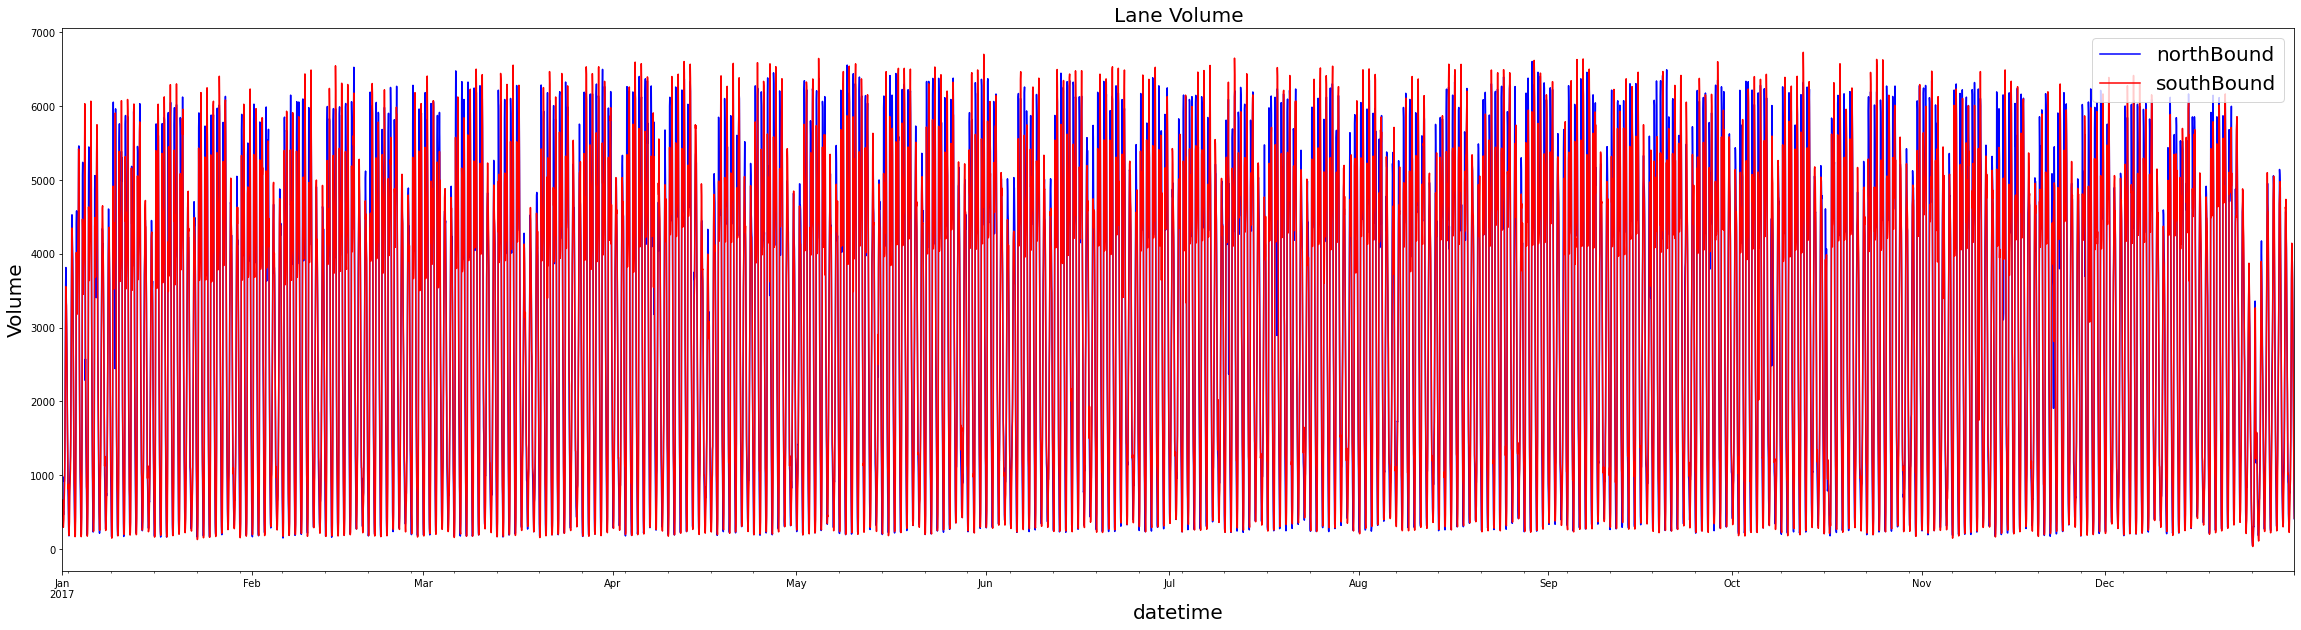

In [3]:
# Get our dataframe
df = load_dataframe()
visualise_dataset(df) # Visualised for a single year

This doesn't tell us a huge amount. Let's split the volume directions up into separate dataframes and have a closer look.

In [4]:
# Create two separate data frames, one for each junction
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

For each dataframe, let's look at a seasonality and trend plot. This could illuminate some more details to us

Base MSE for northBound traffic is: 580.0189445222752
Base MSE for southBound traffic is: 571.777911853327


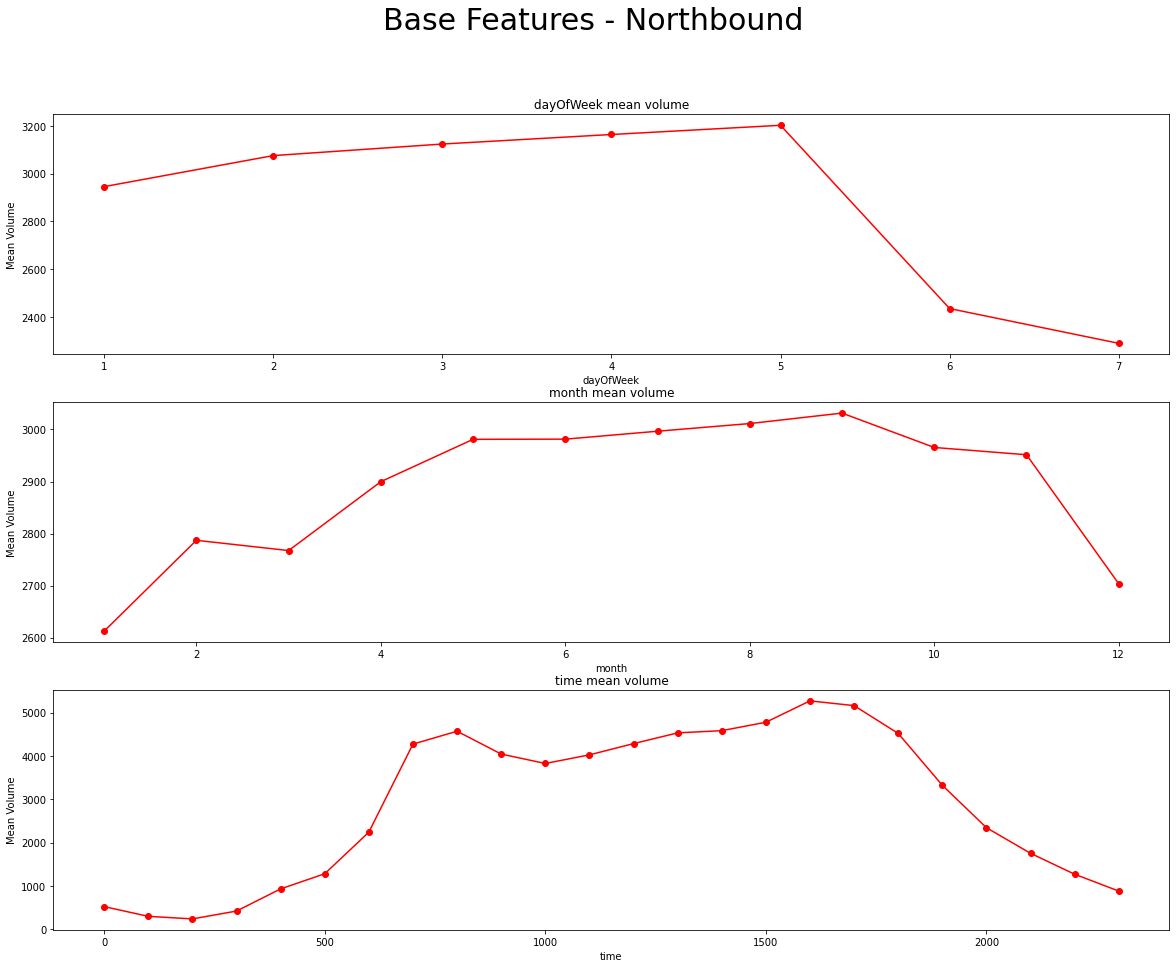

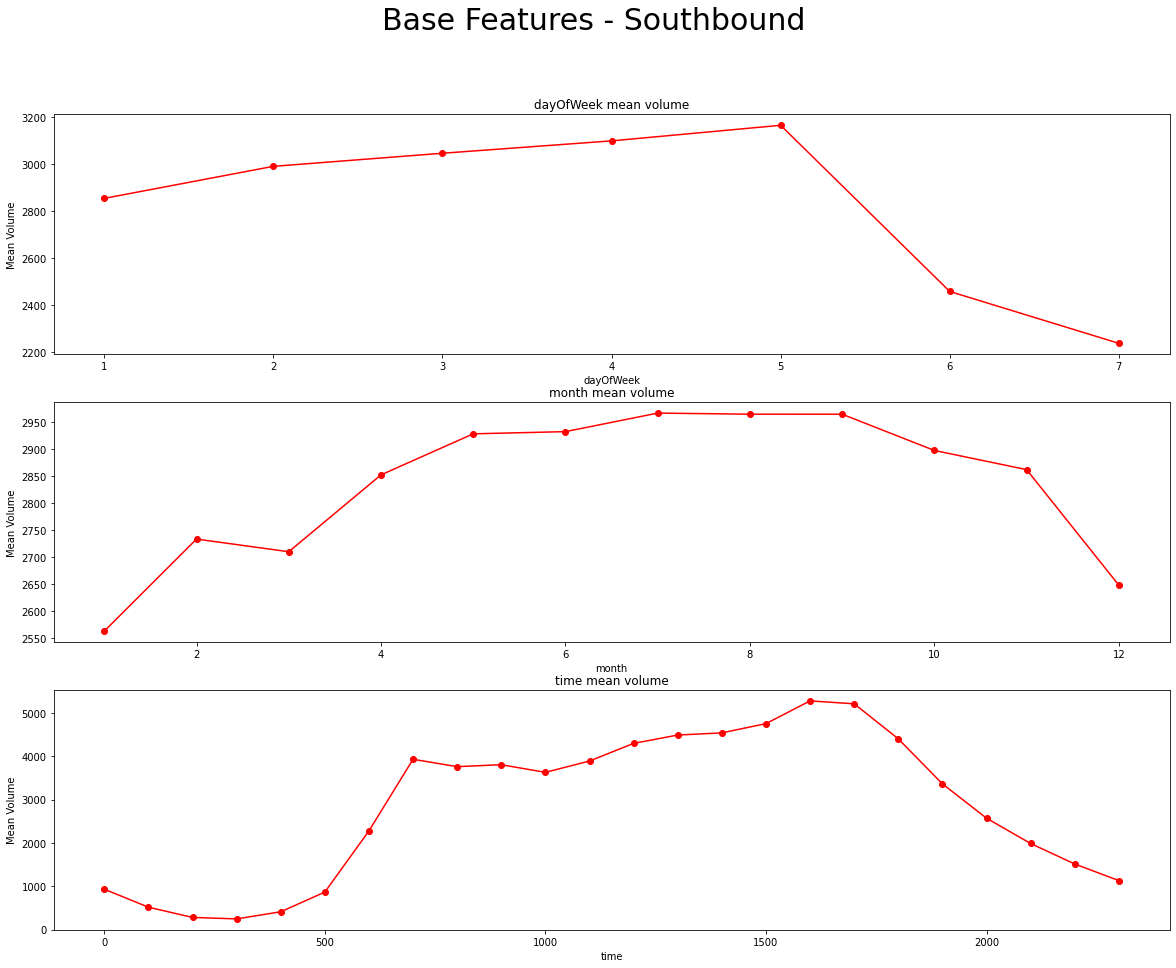

In [5]:
# Base features performance, where we use K Nearest Neighbors.
# Here is our baseline, now we add features.
performance(df_north, "northBound")
visualise_features(["dayOfWeek", "month", "time"], df_north, f"Base Features - Northbound", "northBound")

performance(df_south, "southBound")
visualise_features(["dayOfWeek", "month", "time"], df_south, f"Base Features - Southbound", "southBound")

### We see:
1. A weekly seasonality
2. A yearly seasonality
3. No overall trend throughout the year

### Extra Features

In [6]:
df_north["quarter"] = df.index.quarter
df_north["weekOfYear"] = df.index.weekofyear
df_north["dayOfYear"] = df.index.dayofyear

df_south["quarter"] = df.index.quarter
df_south["weekOfYear"] = df.index.weekofyear
df_south["dayOfYear"] = df.index.dayofyear

/tmp/ipykernel_2464/3101943268.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_north["weekOfYear"] = df.index.weekofyear
/tmp/ipykernel_2464/3101943268.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_south["weekOfYear"] = df.index.weekofyear


In [7]:
performance(df_north, "northBound")
# visualise_features(["quarter", "weekOfYear", "dayOfYear"], df_north, "Additional Features", "northBound")


performance(df_south, "southBound")
# visualise_features(["quarter", "weekOfYear", "dayOfYear"], df_south, "Additional Features", "southBound")

Base MSE for northBound traffic is: 558.4630049749949
Base MSE for southBound traffic is: 557.6665390866111


Let's try some more date-related features

In [8]:
# Get our dataframes back to original features by running cell towards top
# df_north = df.drop(columns=["southBound"])
# df_south = df.drop(columns=["northBound"])

import pandas as pd
ireland_holidays = {(1,1), (17,3), (5,4), (3,5), (7,6), (2,8), (25,10), (25,12), (26,12)}

# Define a function to use in our mapping
def f(x):
    day = x.day
    month = x.month
    if((day,month) in ireland_holidays):
        return 1
    return 0

df_north["weekday"] = df.index.weekday
series = pd.Series(df_north.index).apply(f)
df_north["holiday"] = series.to_list()
df_north = df_north.fillna(0)

df_south["weekday"] = df.index.weekday
series = pd.Series(df_south.index).apply(f)
df_south["holiday"] = series.to_list()
df_south = df_south.fillna(0)


# Check performance
performance(df_north, "northBound")
performance(df_south, "southBound")

Base MSE for northBound traffic is: 509.6211249030781
Base MSE for southBound traffic is: 510.0908069591362


In [9]:
df_north

,dayOfWeek,month,time,northBound,quarter,weekOfYear,dayOfYear,weekday,holiday
datetime,,,,,,,,,
2014-01-01 00:00:00,3,1,0,374.0,1,1,1,2,1
2014-01-01 01:00:00,3,1,100,647.0,1,1,1,2,1
2014-01-01 02:00:00,3,1,200,420.0,1,1,1,2,1
2014-01-01 03:00:00,3,1,300,372.0,1,1,1,2,1
2014-01-01 04:00:00,3,1,400,440.0,1,1,1,2,1
...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,1,12,1900,2211.0,4,1,365,0,0
2018-12-31 20:00:00,1,12,2000,1766.0,4,1,365,0,0
2018-12-31 21:00:00,1,12,2100,1092.0,4,1,365,0,0


### Review:
Looks like our base features and final two features do best.
Newer features perform quite poorly, though this could be because we have such a small dataset right now.#
However, the dayOfYear plot demonstrates some pretty significant seasonality.

## Feature Engineering
### Create lagging features
#### Need to encode components of time series data such as seasonality, trend and cycles.

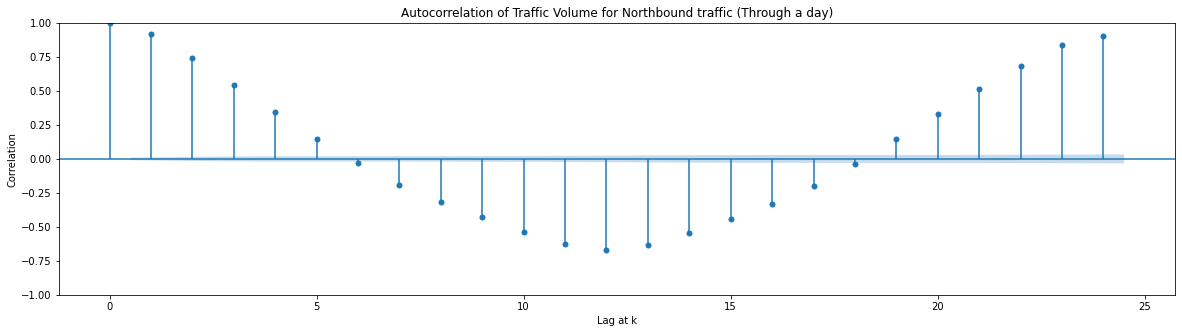

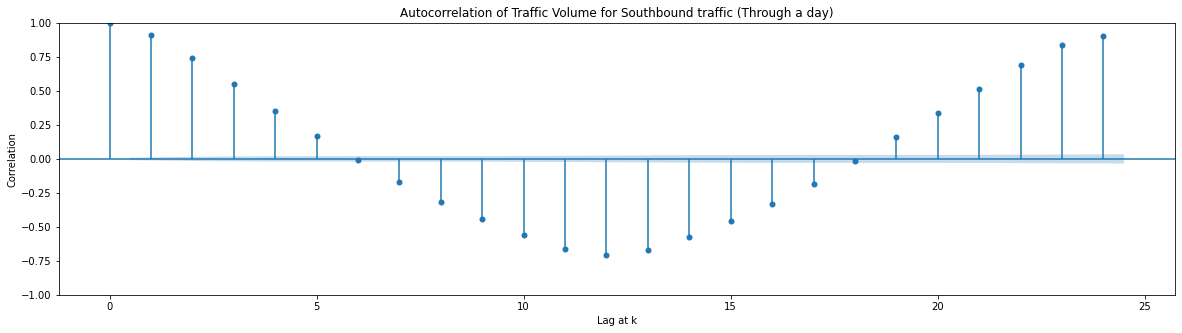

In [10]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

rcParams["figure.figsize"] = 20, 5
fig = plot_acf(df_north["northBound"], lags=24)

plt.title("Autocorrelation of Traffic Volume for Northbound traffic (Through a day)")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
fig.show()

rcParams["figure.figsize"] = 20, 5
fig = plot_acf(df_south["southBound"], lags=24)

plt.title("Autocorrelation of Traffic Volume for Southbound traffic (Through a day)")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
fig.show()

# rcParams["figure.figsize"] = 20, 5
# fig = plot_acf(df_north["northBound"], lags=24)

# plt.title("Autocorrelation of Traffic Volume for Northbound traffic (Through a day)")
# plt.ylabel("Correlation")
# plt.xlabel("Lag at k")
# fig.show()

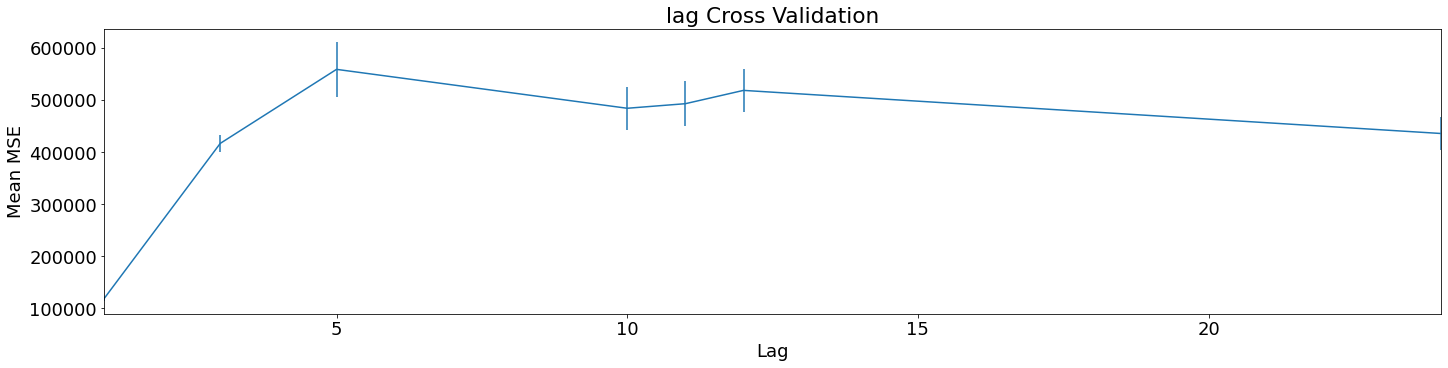

Base MSE for northBound traffic is: 323.5080632521468
Base MSE for northBound traffic is: 279.06658082262817
Base MSE for northBound traffic is: 268.80281912625384
Base MSE for northBound traffic is: 256.9191724935869
Base MSE for northBound traffic is: 252.47422191179237
Base MSE for northBound traffic is: 248.26839969640628
Base MSE for northBound traffic is: 245.24766006907734
Base MSE for northBound traffic is: 236.90058973349835
Base MSE for northBound traffic is: 238.7189885948947


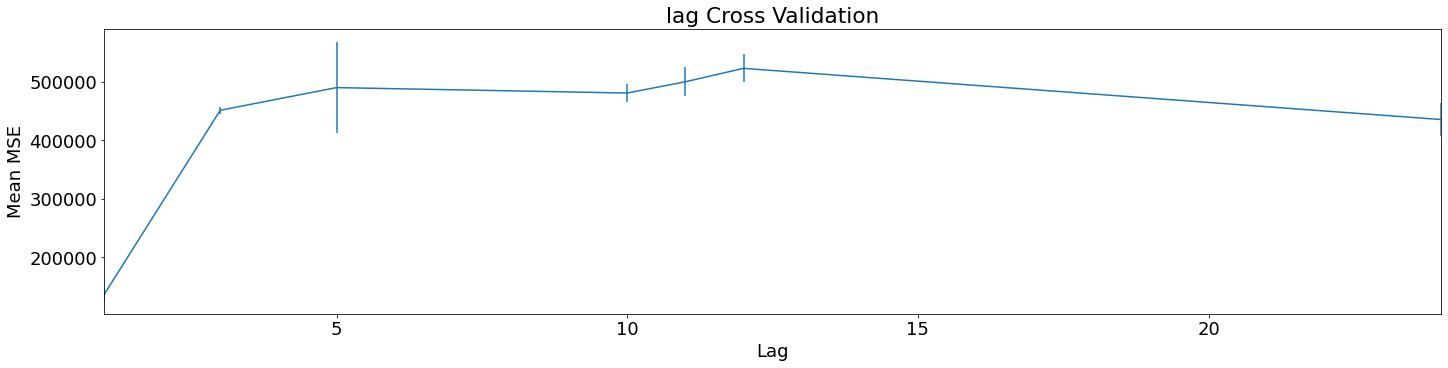

In [11]:
temp = df_north.copy()
cross_validation_feature_params(test_params=[1,3,5,10,11,12,24], df=temp, feature_type="lag", target_var="northBound")

temp_south = df_south.copy()
cross_validation_feature_params(test_params=[1,3,5,10,11,12,24], df=temp_south, feature_type="lag", target_var="southBound")

# Hour
temp["volume_lag_1"] = temp["northBound"].shift(1, fill_value=0)
performance(temp, "northBound")
temp["volume_lag_2"] = temp["northBound"].shift(2, fill_value=0)
performance(temp, "northBound")
temp["volume_lag_3"] = temp["northBound"].shift(3, fill_value=0)
performance(temp, "northBound")
temp["volume_lag_4"] = temp["northBound"].shift(4, fill_value=0)
performance(temp, "northBound")
temp["volume_lag_5"] = temp["northBound"].shift(5, fill_value=0)
performance(temp, "northBound")
temp["volume_lag_6"] = temp["northBound"].shift(6, fill_value=0)
performance(temp, "northBound")
# Difference features
temp["volume_lag_1_diff"] = temp["volume_lag_1"] - temp["northBound"].shift(2, fill_value=0)
performance(temp, "northBound")
# 12 hours
temp["volume_lag_halfday"] = temp["northBound"].shift(12, fill_value=0)
performance(temp, "northBound")
# Day
temp["volume_lag_24"] = temp["northBound"].shift(24, fill_value=0)
performance(temp, "northBound")
# # Week
# temp["volume_lag_week"] = temp["northBound"].shift(168, fill_value=0)
# performance(temp, "northBound")


Set lags, and a difference

In [12]:
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

df_north = df.drop(columns=["southBound"])
df_north["volume_lag_1"] = df_north["northBound"].shift(1, fill_value=0)
df_north["volume_lag_2"] = df_north["northBound"].shift(2, fill_value=0)
df_north["volume_lag_3"] = df_north["northBound"].shift(3, fill_value=0)
df_north["volume_lag_4"] = df_north["northBound"].shift(4, fill_value=0)
df_north["volume_lag_5"] = df_north["northBound"].shift(5, fill_value=0)
df_north["volume_lag_6"] = df_north["northBound"].shift(6, fill_value=0)
df_north["volume_lag_12"] = df_north["northBound"].shift(12, fill_value=0)
df_north["volume_lag_1_diff"] = df_north["volume_lag_1"] - df_north["northBound"].shift(2, fill_value=0)
performance(df_north, "northBound")

df_south = df.drop(columns=["northBound"])
df_south["volume_lag_1"] = df_south["southBound"].shift(1, fill_value=0)
df_south["volume_lag_2"] = df_south["southBound"].shift(2, fill_value=0)
df_south["volume_lag_3"] = df_south["southBound"].shift(3, fill_value=0)
df_south["volume_lag_4"] = df_south["southBound"].shift(4, fill_value=0)
df_south["volume_lag_5"] = df_south["southBound"].shift(5, fill_value=0)
df_south["volume_lag_6"] = df_south["southBound"].shift(6, fill_value=0)
df_south["volume_lag_12"] = df_south["southBound"].shift(12, fill_value=0)
df_south["volume_lag_1_diff"] = df_south["volume_lag_1"] - df_south["southBound"].shift(2, fill_value=0)
performance(df_south, "southBound")

Base MSE for northBound traffic is: 247.82967635615958
Base MSE for southBound traffic is: 305.0213723848665


Interesting that the southbound performance doesnt improve to the same extent

We see better performance as we dont have the cross validated features also in the dataframe. 
This performance is particularly good for such a basic model!

## Model Tuning

We're going to try a few different models provided by sklearn. We could look beyond into things like Keras, ARIMA and XGBOOST, but I don't think it's necessary for this assignment.


Hold out a validation set. This will be used later once we've narrowed down the params for each model.

In [13]:
# We're going to hold out 12 hours of data points to predict on!~
def train_test_split(X,y,test_size):
	return (X[:-test_size, :], X[-test_size:, :], y[:-test_size], y[-test_size:])

In [14]:
# Forecast size
n_forecast = 10
lag_range = 12

In [15]:
# 12-previous points
lagged_points = df_north.to_numpy()[-12-lag_range-1:-12]  # This gives us last twelve rows of training data
lagged_points = lagged_points[
    :, 3
]  # Get the volume for each row, these are our lagged points


# Target Variable
y_north = df_north["northBound"].to_numpy()
y_south = df_south["southBound"].to_numpy()

# Feature Vectors
X_north = df_north.drop(columns=["northBound"]).to_numpy()
X_south = df_south.drop(columns=["southBound"]).to_numpy()

# Hold out a validation set
(X_north, X_north_val, y_north, y_north_val) = train_test_split(X_north, y_north, test_size=n_forecast)
(X_south, X_south_val, y_south, y_south_val) = train_test_split(X_south, y_south, test_size=n_forecast)



So, let's look into Lasso and Ridge Regression first.

/home/tom/miniconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e+07, tolerance: 2.337e+06
  model = cd_fast.enet_coordinate_descent(
/home/tom/miniconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.016e+07, tolerance: 4.807e+06
  model = cd_fast.enet_coordinate_descent(
/home/tom/miniconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

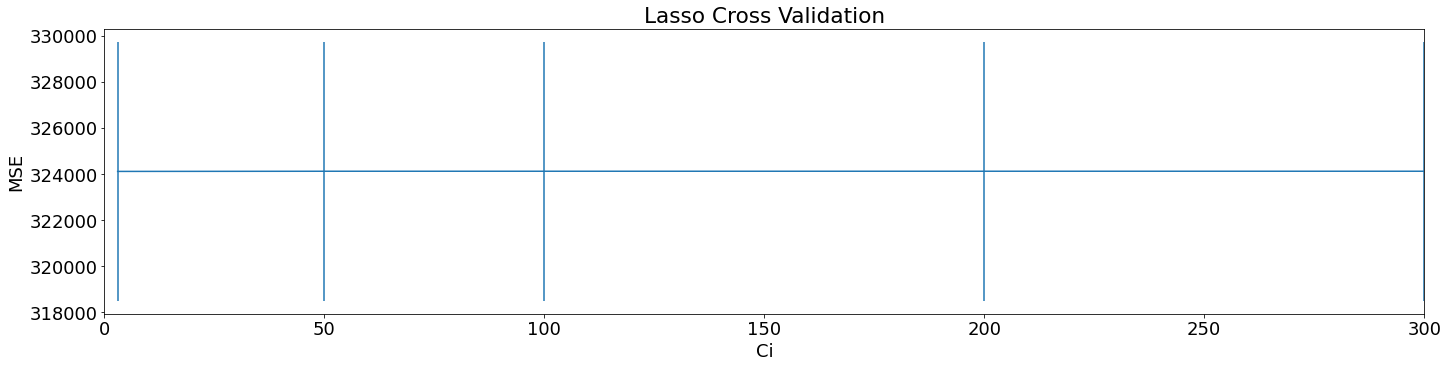

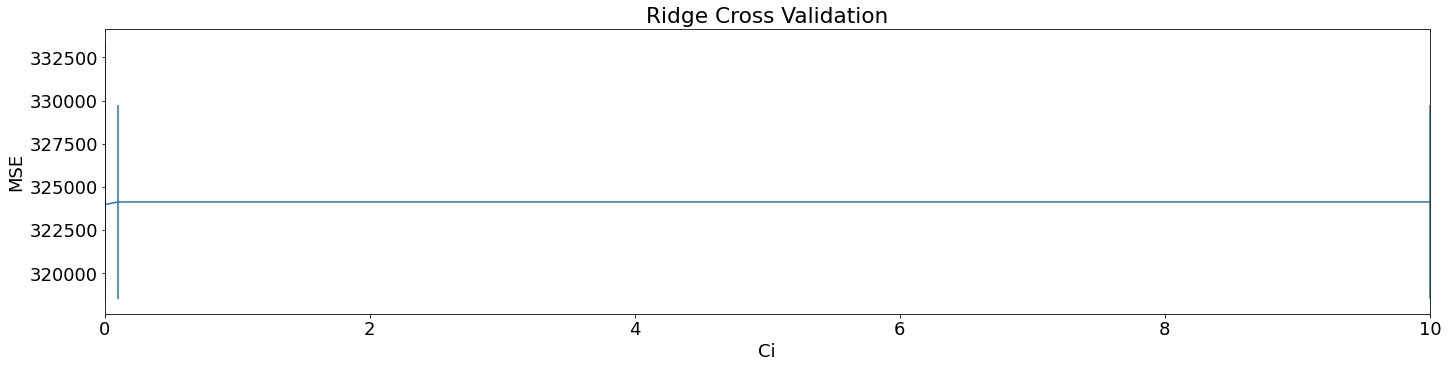

In [16]:
from models import evaluate_lasso_hyperparams, evaluate_ridge_hyperparams
evaluate_lasso_hyperparams(X_north,y_north, [3,50,100,200,300])
evaluate_ridge_hyperparams(X_north,y_north, [0.000001,0.0001,0.1,10])


Pretty awful performance lol. Not really surprising though. What is surprising is how well kNN does...

Get params for KNN

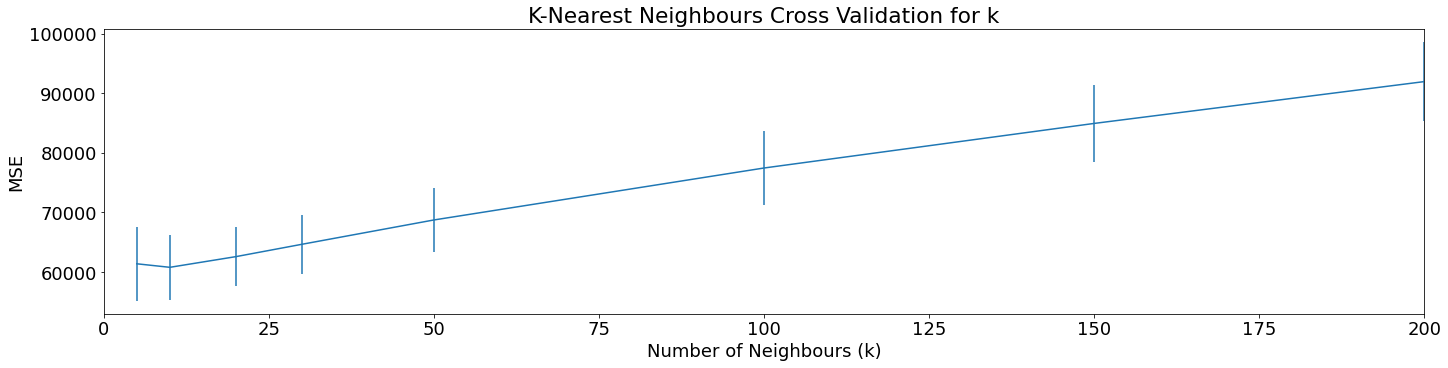

In [19]:
from models import evaluate_knn_k, evaluate_knn_k
evaluate_knn_k(X_north,y_north, [5,10,20,30,50,100,150,200])
# Not using gaussian weighting, seems to cause issues.
# 10 does best. This is interesting! Usually for large datasets, largers k's are better.
# For time series data though it makes sense!

Lets try build on our decision tree using AdaBoost
Tuning parameters takes a while so I'll leave it commented out

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

from models import evaluate_ada_boost_hyperparams
from utilities import get_decision_tree_models

params_grid={
    "base_estimator": [model for model in get_decision_tree_models(max_depth_array=range(1,20))],
    "n_estimators":[i for i in range(5,150,5)],
    "learning_rate":[0.01,0.1,1,1.5,2,5,10],
    "loss":['linear', 'square', 'exponential']
}

#evaluate_ada_boost_hyperparams(X_north,y_north,params_grid) 

In [ ]:
ada_boost_model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=15),
    n_estimators=90,
    learning_rate=0.01,
    loss='exponential').fit(X_north,y_north)

scores = cross_validate(
        ada_boost_model,
        X_north,
        y_north,
        cv=cv,
        scoring="neg_mean_squared_error",
        return_estimator=True,
    )

base_mse = np.sqrt(-np.mean(scores["test_score"]))
print(f"Ada Boost Performance MSE is: {format(base_mse)}")


Bit better than the original decision tree..

Random Grid search to find the best combination of params for a random forest.
With those best params, we then test the performance. Takes a while...

In [23]:
from models import evaluate_random_forest_hyperparams
test_params = {
"n_estimators": [20, 50, 60, 100],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [i for i in range(5,20)]
}
evaluate_random_forest_hyperparams(X_north, y_north, test_params)

{'n_estimators': 50, 'max_features': 'log2', 'max_depth': 16}


In [ ]:
# get a figure for the performance
from sklearn.ensemble import RandomForestRegressor
cv = TimeSeriesSplit(n_splits=5)
rf_model = RandomForestRegressor(n_estimators=60, max_features="auto",max_depth=14)
scores = cross_validate(
        rf_model,
        X_north,
        y_north,
        cv=cv,
        scoring="neg_mean_squared_error",
        return_estimator=True,
    )

base_mse = np.sqrt(-np.mean(scores["test_score"]))
print(f"MSE is: {format(base_mse)}")

MSE is: 258.15017806547326


Let's get the best hyper params for an ANN. We'll plot the error bars for it since the slides do it. Takes about six minutes to run... Comment it out then run it once everything else is done.

In [25]:
# from models import evaluate_MLP_hidden_nodes, evaluate_MLP_penalty_weight
# evaluate_MLP_hidden_nodes(X_north,y_north, [5,10,15,30,50,100])
# evaluate_MLP_penalty_weight(X_north,y_north, [0.1,1,10,100,1000])

## Validation
1. KNN


2074467.5746793752


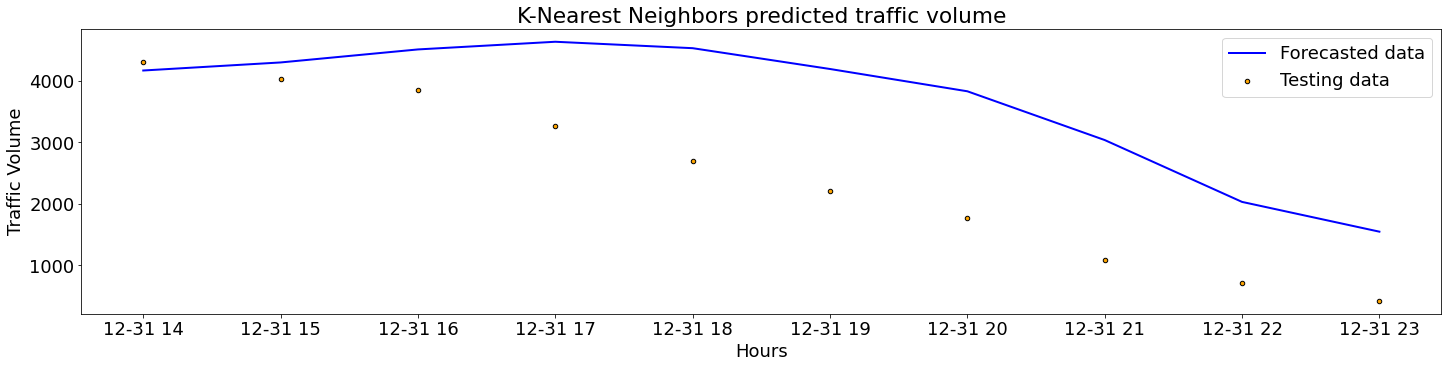

In [85]:
from sklearn.neighbors import KNeighborsRegressor
from forecasting import n_one_step_ahead_prediction
from sklearn.metrics import mean_squared_error
knn_model = KNeighborsRegressor(n_neighbors=10, weights="distance").fit(X_north, y_north)
y_forecast_north = n_one_step_ahead_prediction(knn_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print(mean_squared_error(y_north_val, y_forecast_north))

# Visualise
from visualisation import visualise_forecast_vs_true
x_axis = df.iloc[-n_forecast:].index.to_numpy()
visualise_forecast_vs_true(x_axis, y_north_val, y_forecast_north, model_name="K-Nearest Neighbors")

2. Decision Tree

MSE: 1368800.5487448885


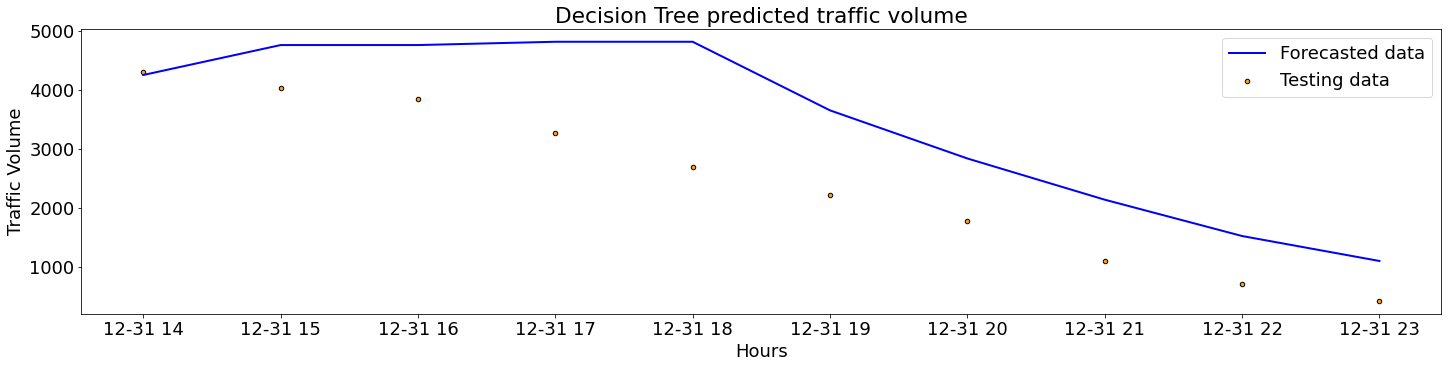

In [89]:
from sklearn.tree import DecisionTreeRegressor
y_forecast_north = n_one_step_ahead_prediction(decision_tree_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print("MSE: "+str(mean_squared_error(y_north_val, y_forecast_north)))
x_axis = df.iloc[-n_forecast:].index.to_numpy()
visualise_forecast_vs_true(x_axis,y_north_val,y_forecast_north,"Decision Tree")

2. Ada Boost

MSE: 169293.34444444446


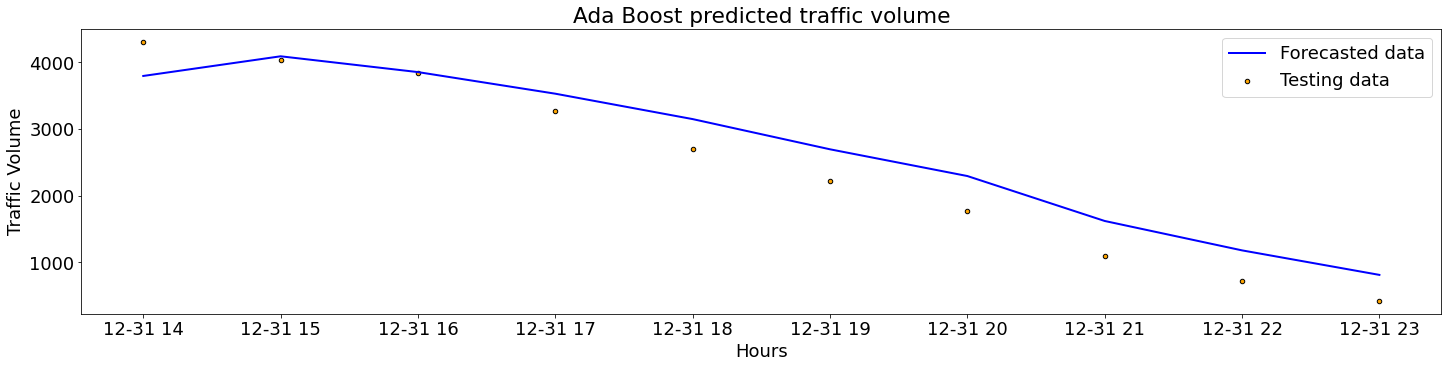

In [91]:
from sklearn.ensemble import AdaBoostRegressor
ada_boost_model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=15),
    n_estimators=90,
    learning_rate=0.01,
    loss='exponential').fit(X_north,y_north)
y_forecast_north = n_one_step_ahead_prediction(ada_boost_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print("MSE: "+str(mean_squared_error(y_north_val, y_forecast_north)))
x_axis = df.iloc[-n_forecast:].index.to_numpy()
visualise_forecast_vs_true(x_axis,y_north_val,y_forecast_north,"Ada Boost")

3. Random Forest

210324.77730023224


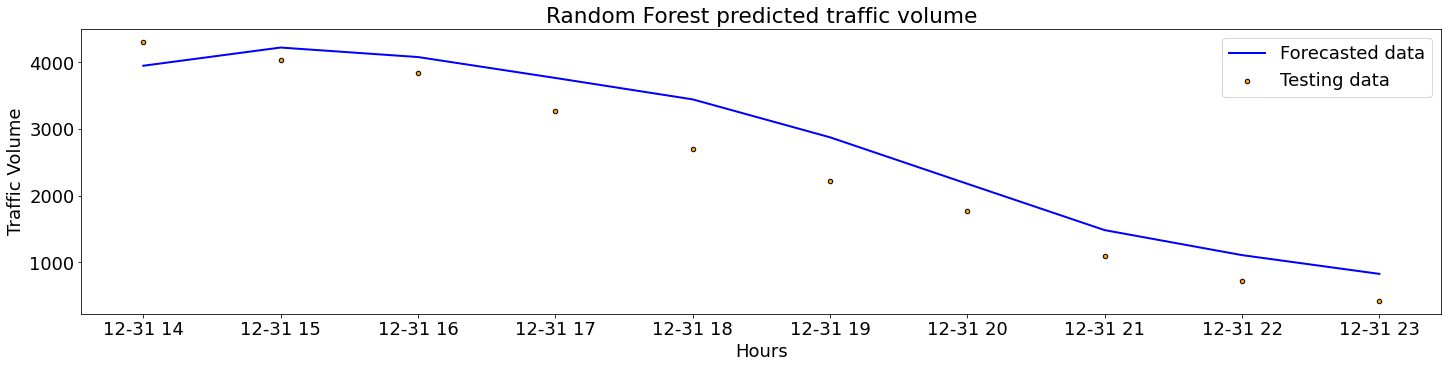

In [79]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=60, max_features="auto",max_depth=14).fit(X_north, y_north)
y_forecast_north = n_one_step_ahead_prediction(rf_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print(mean_squared_error(y_north_val, y_forecast_north))

# Visualise this
visualise_forecast_vs_true(x_axis, y_north_val, y_forecast_north, model_name="Random Forest")

If the results are bad, try again and it'll probably change

4. Neural Network

2709291.604302804


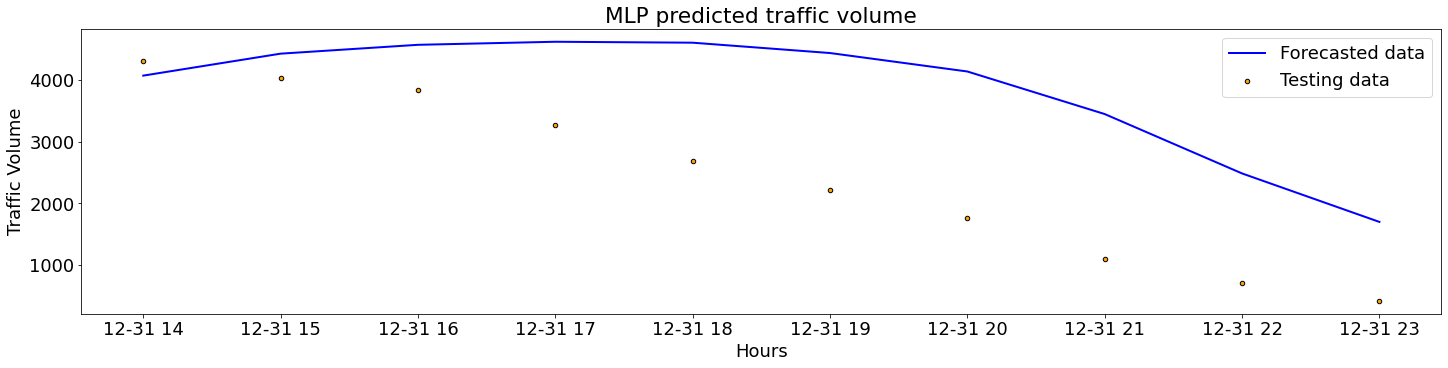

In [84]:
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=100, alpha=1000,max_iter=500).fit(X_north, y_north)
y_forecast_north = n_one_step_ahead_prediction(mlp_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print(mean_squared_error(y_north_val, y_forecast_north))
visualise_forecast_vs_true(x_axis, y_north_val, y_forecast_north, model_name="MLP")